In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


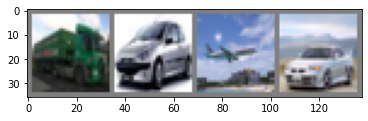

In [11]:
examples = iter(train_loader)
samples, labels = examples.next()

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(samples))

In [12]:
# CNN
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # i/p = nc , o/p 6, kernel size = 5*5
    self.conv1 = nn.Conv2d(3, 6, 5)
    # kernel size = 2, stride = 2
    self.pool = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    # before connectin to fc layers flatten it
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    #no activation function at the end no softmax as we use it with Cross entropy
    # loss
    x = self.fc3(x)

    return x

In [13]:
# TRAINING LOOP

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #updates the weights through gradient in backward 
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/5], Step [2000/12500], Loss: 2.2962
Epoch [1/5], Step [4000/12500], Loss: 2.3108
Epoch [1/5], Step [6000/12500], Loss: 2.2874
Epoch [1/5], Step [8000/12500], Loss: 2.3075
Epoch [1/5], Step [10000/12500], Loss: 2.1691
Epoch [1/5], Step [12000/12500], Loss: 1.8898
Epoch [2/5], Step [2000/12500], Loss: 1.9088
Epoch [2/5], Step [4000/12500], Loss: 2.1811
Epoch [2/5], Step [6000/12500], Loss: 1.9672
Epoch [2/5], Step [8000/12500], Loss: 1.6916
Epoch [2/5], Step [10000/12500], Loss: 1.7679
Epoch [2/5], Step [12000/12500], Loss: 1.8898
Epoch [3/5], Step [2000/12500], Loss: 1.0238
Epoch [3/5], Step [4000/12500], Loss: 1.4744
Epoch [3/5], Step [6000/12500], Loss: 1.1102
Epoch [3/5], Step [8000/12500], Loss: 1.1267
Epoch [3/5], Step [10000/12500], Loss: 1.7855
Epoch [3/5], Step [12000/12500], Loss: 1.4197
Epoch [4/5], Step [2000/12500], Loss: 1.7248
Epoch [4/5], Step [4000/12500], Loss: 1.0343
Epoch [4/5], Step [6000/12500], Loss: 1.8265
Epoch [4/5], Step [8000/12500], Loss: 1.1382
Epoc

In [14]:
# Testing the model

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    # Accuracy achieved in each class
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 47.12 %
Accuracy of plane: 61.3 %
Accuracy of car: 51.6 %
Accuracy of bird: 39.9 %
Accuracy of cat: 18.1 %
Accuracy of deer: 35.7 %
Accuracy of dog: 44.4 %
Accuracy of frog: 51.2 %
Accuracy of horse: 68.5 %
Accuracy of ship: 56.6 %
Accuracy of truck: 43.9 %
